# Primer ejemplo de LSTM
Alejandro Ozymandias Cepeda Beltran

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### 1. CONFIGURACIÓN Y GENERACIÓN DE DATOS
Vamos a enseñar a la red a predecir la función SENO. Dada una secuencia de 50 puntos, debe predecir el punto 51.

In [16]:
def crear_secuencias(datos, ventana):
    """
    Transforma una serie plana en pares (entrada, objetivo).
    Entrada: [0, 1, 2, 3, 4] y ventana=3
    Salida X: [[0,1,2], [1,2,3]]
    Salida y: [3, 4]
    """
    secuencias = []
    labels = []
    L = len(datos)
    for i in range(L - ventana):
        # Tomamos 'ventana' pasos como input
        seq = datos[i : i + ventana]
        # El siguiente paso es lo que queremos predecir
        label = datos[i + ventana]
        secuencias.append(seq)
        labels.append(label)
    return np.array(secuencias), np.array(labels)

# Crear datos de onda senoidal
t = np.linspace(0, 100, 1000)
datos = np.sin(t)

# Hiperparámetros
ventana_tiempo = 50  # Cuántos pasos hacia atrás mira la red
test_size = 200

# Preparar dataset
X, y = crear_secuencias(datos, ventana_tiempo)

X


array([[ 0.        ,  0.09993302,  0.19886554, ..., -0.99997048,
        -0.9957327 , -0.98152597],
       [ 0.09993302,  0.19886554,  0.29580708, ..., -0.9957327 ,
        -0.98152597, -0.95749254],
       [ 0.19886554,  0.29580708,  0.3897871 , ..., -0.98152597,
        -0.95749254, -0.92387301],
       ...,
       [ 0.52014028,  0.60288742,  0.67959865, ..., -0.85805249,
        -0.80243543, -0.73878464],
       [ 0.60288742,  0.67959865,  0.74950597, ..., -0.80243543,
        -0.73878464, -0.6677374 ],
       [ 0.67959865,  0.74950597,  0.81190948, ..., -0.73878464,
        -0.6677374 , -0.59000499]], shape=(950, 50))

### 2. PREPARACIÓN DE TENSORES
La LSTM espera input de forma: (Batch_Size, Sequence_Length, Input_Size). Aquí Input_Size es 1 (porque solo tenemos 1 valor: la amplitud del seno)

In [17]:
# Dividir en train/test
train_X = torch.Tensor(X[:-test_size])
train_y = torch.Tensor(y[:-test_size])
test_X = torch.Tensor(X[-test_size:])
test_y = torch.Tensor(y[-test_size:])

# Añadir la dimensión de "Features" (Input_Size) al final
# De (Batch, 50) pasamos a (Batch, 50, 1)
train_X = train_X.unsqueeze(-1)
test_X = test_X.unsqueeze(-1)
# Las etiquetas también necesitan forma correcta para el Loss
train_y = train_y.unsqueeze(-1)
test_y = test_y.unsqueeze(-1)

print(f"Forma de entrada a la LSTM: {train_X.shape}") # (Batch, 50, 1)

Forma de entrada a la LSTM: torch.Size([750, 50, 1])


### 3. definición del modelo

In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1, num_layers=1):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Definición de la capa LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,     # 1 (solo el valor del seno)
            hidden_size=hidden_dim,   # 50 neuronas en la memoria
            num_layers=num_layers,    # 1 capa apilada
            batch_first=True          # Importante para usar (Batch, Seq, Feat)
        )
        
        # Capa lineal para decodificar la salida de la LSTM a un solo valor
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)
        
        # LSTM devuelve: output, (hidden_state, cell_state)
        # output contiene los estados ocultos de TODA la secuencia
        lstm_out, _ = self.lstm(x)
        
        # Solo nos interesa la predicción del ÚLTIMO paso de tiempo
        # Tomamos el último slice temporal: [:, -1, :]
        last_time_step = lstm_out[:, -1, :]
        
        # Pasamos por la lineal para obtener la predicción final
        prediccion = self.linear(last_time_step)
        
        return prediccion
    
# Instanciar modelo, pérdida y optimizador
modelo = LSTMPredictor()
loss_function = nn.MSELoss() # Error Cuadrático Medio (estándar para regresión)
# Optimizador Adam con learning rate de 0.001
optimizer = optim.Adam(modelo.parameters(), lr=0.001)


### 4. Entrenamiento

In [7]:
epochs = 15
print("\nIniciando entrenamiento...")

for i in range(epochs):
    modelo.train()
    
    # 1. Resetear gradientes
    optimizer.zero_grad()
    
    # 2. Forward pass (Predecir)
    y_pred = modelo(train_X)
    
    # 3. Calcular pérdida
    loss = loss_function(y_pred, train_y)
    
    # 4. Backward pass (Calcular gradientes)
    loss.backward()
    
    # 5. Actualizar pesos
    optimizer.step()
    
    if i % 5 == 0:
        print(f'Epoch {i} Loss: {loss.item():.6f}')

print("Entrenamiento finalizado.\n")


Iniciando entrenamiento...
Epoch 0 Loss: 0.489315
Epoch 5 Loss: 0.452905
Epoch 10 Loss: 0.413136
Entrenamiento finalizado.



### 5. Evaluación

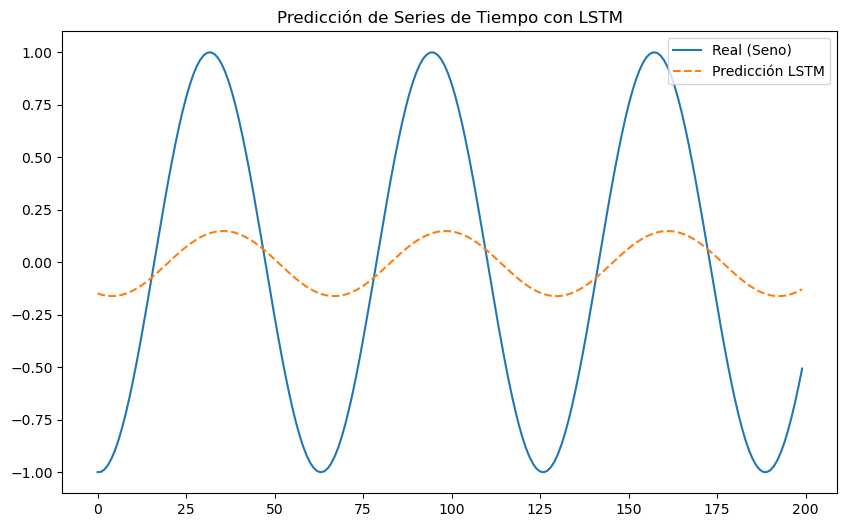

Ejemplo de predicción vs real:
Real: -0.9995 | Predicho: -0.1486


In [18]:
modelo.eval()
with torch.no_grad():
    test_pred = modelo(test_X)

# Convertir a numpy para graficar
real = test_y.numpy()
predicho = test_pred.numpy()

# Descomenta las siguientes líneas si estás en un entorno con pantalla gráfica (Jupyter/Local)
plt.figure(figsize=(10,6))
plt.plot(real, label='Real (Seno)')
plt.plot(predicho, label='Predicción LSTM', linestyle='dashed')
plt.legend()
plt.title('Predicción de Series de Tiempo con LSTM')
plt.show()

print("Ejemplo de predicción vs real:")
print(f"Real: {real[0][0]:.4f} | Predicho: {predicho[0][0]:.4f}")